# Web Traffic Forecasting - Part 4: Deep Learning - Prophet & Model Comparison #

In [ ]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm, tnrange
from fbprophet import Prophet

In [ ]:
# !pip install pystan~=2.14
# !pip install fbprophet
!ls

sample_data


In [ ]:
import datetime
import random

In [ ]:
# Please change the path of this data file into the correct path of your own google drivef
rom google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# read raw data
df = pd.read_csv('data/train_2.csv')

In [ ]:
df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,3.0,6.0,5.0,2.0,4.0,4.0,8.0,2.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,7.0,5.0,0.0,5.0,5.0,2.0,2.0,4.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,25.0,22.0,47.0,42.0,13.0,9.0,21.0,16.0,6.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,6.0,5.0,1.0,5.0,8.0,2.0,4.0,3.0,3.0


In [ ]:
#unpivot the data to meet the requirement of prophet
newdf = pd.melt(df, id_vars=['Page'], value_vars=df.columns[1:])
newdf = newdf.sort_values(by=['Page','variable'])

In [ ]:
# this is the prediction from LSTM
lstm = pd.read_csv('data/LSTM_preds.csv')

In [ ]:
lstm.columns=['ds','page1','page2','page3','page4','page5']
lstm['ds'] = pd.to_datetime(lstm['ds'])
lstm['ds'] = pd.to_datetime(lstm['ds'],unit='s')
lstm

,ds,page1,page2,page3,page4,page5
0,2017-04-04,5615.8535,6401.7930,4748.6760,4088.2976,7433.2600
1,2017-04-05,5541.5977,6522.1343,4691.4970,4043.3840,7267.4507
2,2017-04-06,5406.0234,6681.7910,4234.3853,4010.4692,7452.6997
3,2017-04-07,5363.2160,6800.3740,3274.9863,4046.6072,6905.3135
4,2017-04-08,6158.4980,6810.9434,2359.1850,3968.4255,3934.3900
...,...,...,...,...,...,...
155,2017-09-06,6602.7620,7054.4844,4764.9990,2836.4820,5963.0977
156,2017-09-07,6594.0330,7195.4307,4257.8433,2847.7840,5764.7720
157,2017-09-08,6536.7686,7390.2800,3169.0781,2670.3184,4629.3080
158,2017-09-09,6529.4120,7549.2236,2090.8616,2593.1748,2534.5880


In [ ]:
#this is prediction from tree model
v = pd.read_csv('data/ML_preds.csv')

In [ ]:
v = v.set_index('Page').T.reset_index()
v.columns=['ds','page1','page2','page3','page4','page5']
v['ds'] = pd.to_datetime(v['ds'])
v['ds'] = pd.to_datetime(v['ds'],unit='s')
v

,ds,page1,page2,page3,page4,page5
0,2017-05-10,5784.660,8673.625,3966.785,4130.205,6708.595
1,2017-05-11,5907.925,7931.535,4075.405,4152.430,6746.465
2,2017-05-12,5799.545,7292.215,3948.340,3998.180,6595.490
3,2017-05-13,5813.745,6922.375,3989.670,3864.245,6970.850
4,2017-05-14,5761.995,6810.810,3770.445,3910.910,6340.335
...,...,...,...,...,...,...
118,2017-09-05,7545.935,6809.045,4264.985,3099.575,4812.060
119,2017-09-06,7222.620,6975.290,4407.585,3026.195,5048.550
120,2017-09-07,7297.385,6380.850,4364.585,3058.890,5035.535
121,2017-09-08,7217.485,6158.640,4434.765,3046.145,5361.305


In [ ]:
import numpy as np
#def a prophet predict block
def prophetoutput(page, sample1):
    m = Prophet()
    m.fit(sample1.iloc[:-30,:])
    future = m.make_future_dataframe(periods=30)
    future.tail()
    forecast = m.predict(future)
    m.plot(forecast)
    m.plot_components(forecast)
    return forecast[['ds','yhat']]
#cal the rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#select 5 pages for prodictions
page= ['Portal:Current_events_en.wikipedia.org_mobile-web_all-agents', \
             'Mary_I_of_England_en.wikipedia.org_mobile-web_all-agents', \
             'List_of_country_calling_codes_en.wikipedia.org_desktop_all-agents', \
             'Lisa_Ann_en.wikipedia.org_mobile-web_all-agents', \
             'Representational_state_transfer_en.wikipedia.org_desktop_all-agents']
p = ['page1','page2','page3','page4','page5']


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.08262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1964.86   0.000202724       81.8468   9.599e-07       0.001      157  LS failed, Hessian reset 
      99       1965.01   0.000333666       75.3963      0.2857           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       1965.31   0.000173396       84.7571   1.072e-06       0.001      260  LS failed, Hessian reset 
     172       1965.43   7.77658e-06       58.4393   1.084e-07       0.001      366  LS failed, Hessian reset 
     188       1965.43   1.08612e-07        44.939     0.06544           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


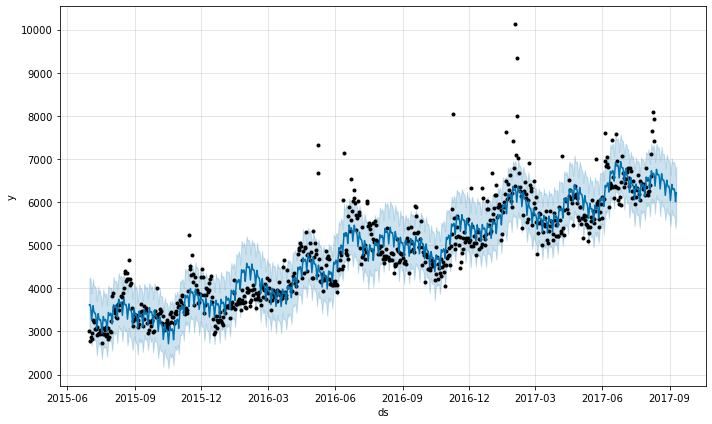

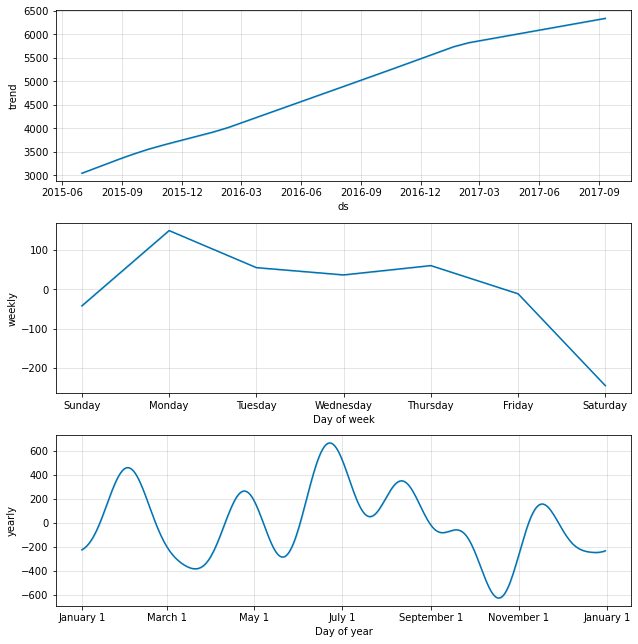

In [ ]:
#page 1
i=0
def doprophet(i):
    a, b = page[i], p[i]

    sample1 = newdf[newdf.Page== a]
    sample1 = sample1[['variable','value']].rename(columns={'variable':'ds', 'value':'y'})
    sample1['ds'] = pd.to_datetime(sample1['ds'])
    sample1['ds'] = pd.to_datetime(sample1['ds'],unit='s')
    page1 = prophetoutput(page, sample1)
    return sample1, page1, a, b
sample1, page1, a, b = doprophet(i)

In [ ]:
print(a,b)

Portal:Current_events_en.wikipedia.org_mobile-web_all-agents page1


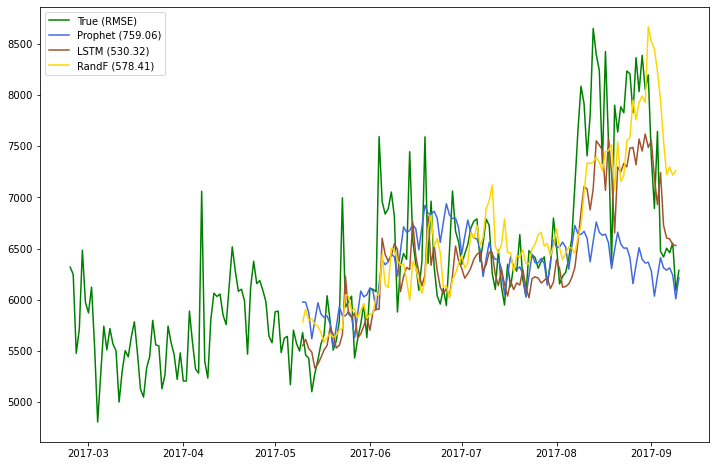

In [ ]:
rmsepro = rmse(np.array(page1.iloc[-124:-1,:]['yhat']), np.array(sample1.iloc[-124:-1,:]['y']))
rmselst = rmse(np.array(lstm.iloc[-124:-1,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))
rmserfr = rmse(np.array(v.iloc[:,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))

def drawconclusion(sample1, page1, a, b):
    plt.figure(figsize=(12,8))
    plt.plot(sample1.iloc[-200:,:]['ds'], sample1.iloc[-200:,:]['y'],label=f'True (RMSE)',color = 'green')
    plt.plot(page1.iloc[-124:,:]['ds'], page1.iloc[-124:,:]['yhat'],label=f'Prophet ({rmsepro:.2f})', color = 'royalblue')
    plt.plot(lstm.iloc[-124:-1,:]['ds'], lstm.iloc[-124:-1,:][b],label=f'LSTM ({rmselst:.2f})', color = 'sienna')
    plt.plot(v.iloc[-123:,:]['ds'], v.iloc[-124:,:][b],label=f'RandF ({rmserfr:.2f})', color = 'gold')
    plt.legend()
    plt.show()
    
drawconclusion(sample1, page1, a, b)

In [ ]:
print(rmsepro)
print(rmselst)
print(rmserfr)

759.0632935629809
530.3162264410807
578.4079737721212


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.31191
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1931.7    0.00915222       90.8868      0.6721           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       1932.08   2.91389e-05       72.3026    3.34e-07       0.001      245  LS failed, Hessian reset 
     199       1932.09   0.000531907       95.3414           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215        1932.2   0.000163635       54.0902   2.536e-06       0.001      356  LS failed, Hessian reset 
     295       1932.31   3.48937e-06       89.4692   4.565e-08       0.001      502  LS failed, Hessian reset 
     299       1932.31   7.29861e-07       57.8286      0.9682      0.9682      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


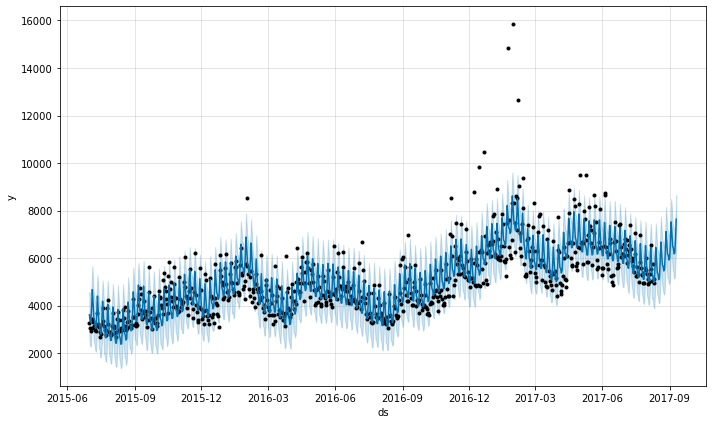

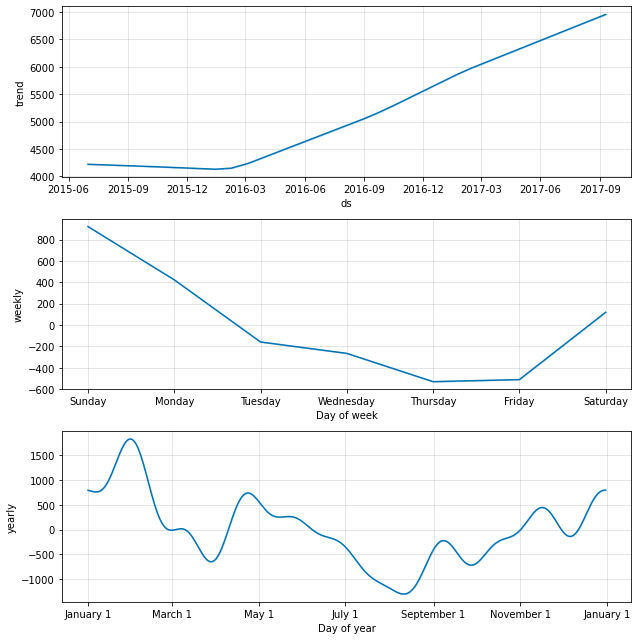

In [ ]:
#page 2
i=1
sample1, page1, a, b = doprophet(i)

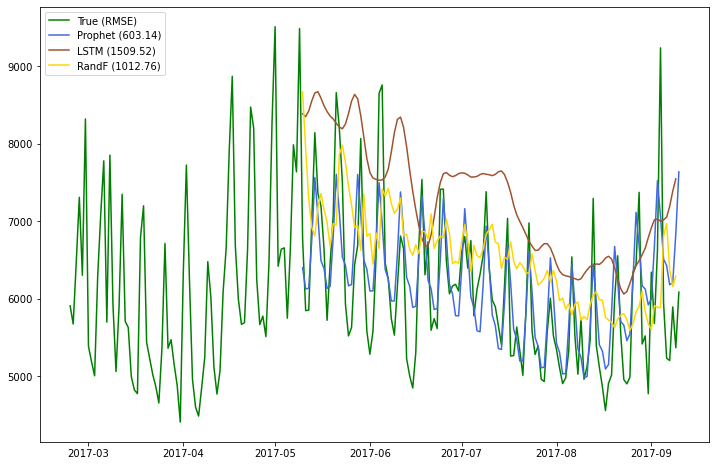

In [ ]:
rmsepro = rmse(np.array(page1.iloc[-124:-1,:]['yhat']), np.array(sample1.iloc[-124:-1,:]['y']))
rmselst = rmse(np.array(lstm.iloc[-124:-1,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))
rmserfr = rmse(np.array(v.iloc[:,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))

drawconclusion(sample1, page1, a, b)

In [ ]:
print(rmsepro)
print(rmselst)
print(rmserfr)

603.1427914792772
1509.5194299767675
1012.7645501390206


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.9751
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1808.18    0.00648823       261.988      0.8839      0.8839      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1811.24   1.79101e-05       62.6504       2.131      0.5344      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       1811.66   0.000455394       145.273   7.455e-06       0.001      381  LS failed, Hessian reset 
     299       1812.02    0.00291136       86.8298      0.2388           1      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       1812.11   5.64458e-05       91.6152   6.537e-07       0.001      506  LS failed, Hessian reset 
     367       1812.11   8.05187e-08       68.7044      0.3503      0.3503      542   
Optimization terminat

/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


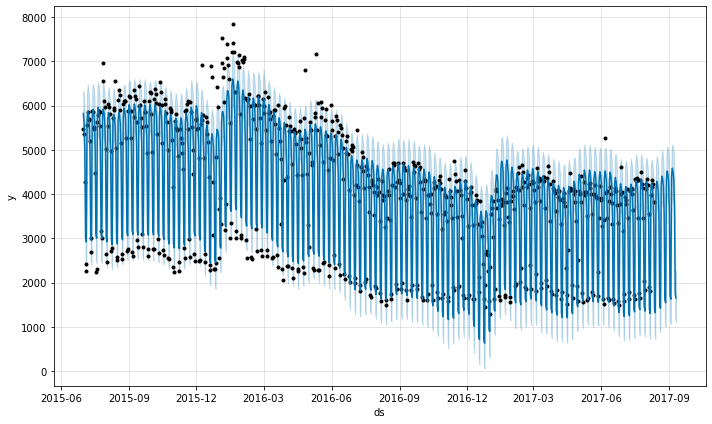

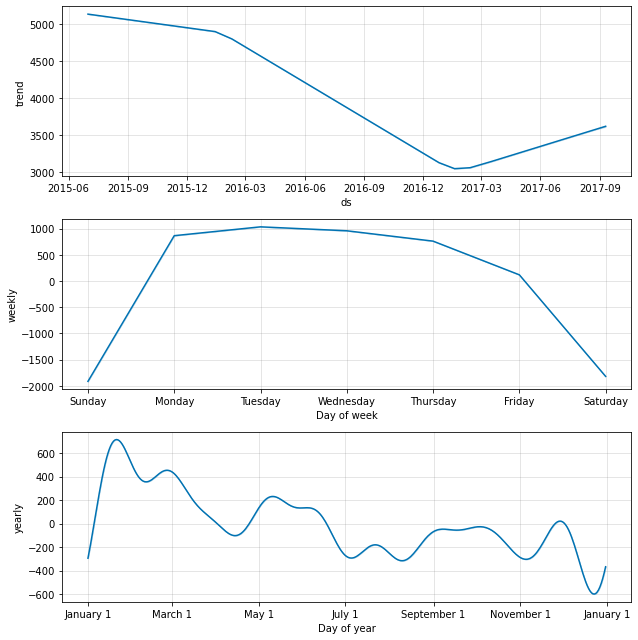

In [ ]:
#page 3
i=2
sample1, page1, a, b = doprophet(i)

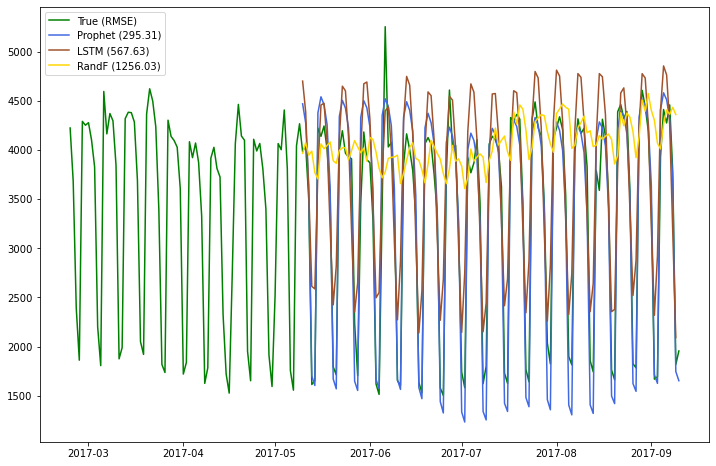

In [ ]:
rmsepro = rmse(np.array(page1.iloc[-124:-1,:]['yhat']), np.array(sample1.iloc[-124:-1,:]['y']))
rmselst = rmse(np.array(lstm.iloc[-124:-1,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))
rmserfr = rmse(np.array(v.iloc[:,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))

drawconclusion(sample1, page1, a, b)

In [ ]:
print(rmsepro)
print(rmselst)
print(rmserfr)

295.3053067692068
567.632929012839
1256.0253181926125


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.02115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       1872.89   0.000494157       74.7769   7.342e-06       0.001      119  LS failed, Hessian reset 
      99       1872.93   2.06104e-06       67.7454      0.2376           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1873.37   9.72488e-05        73.024           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1873.39   0.000117604       73.8234   1.814e-06       0.001      365  LS failed, Hessian reset 
     269       1873.41   9.36485e-08       63.4012      0.4012           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


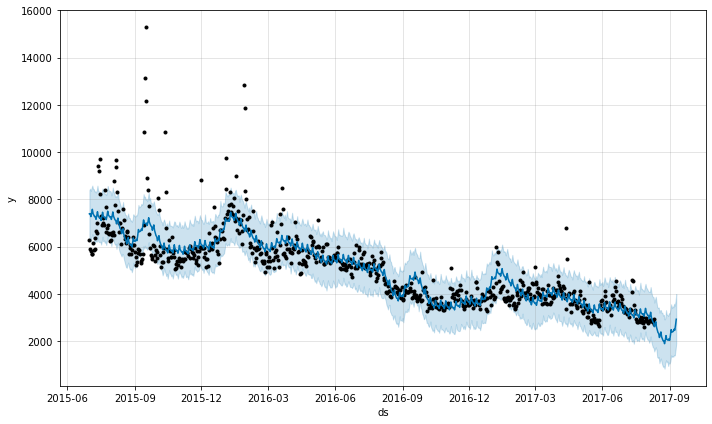

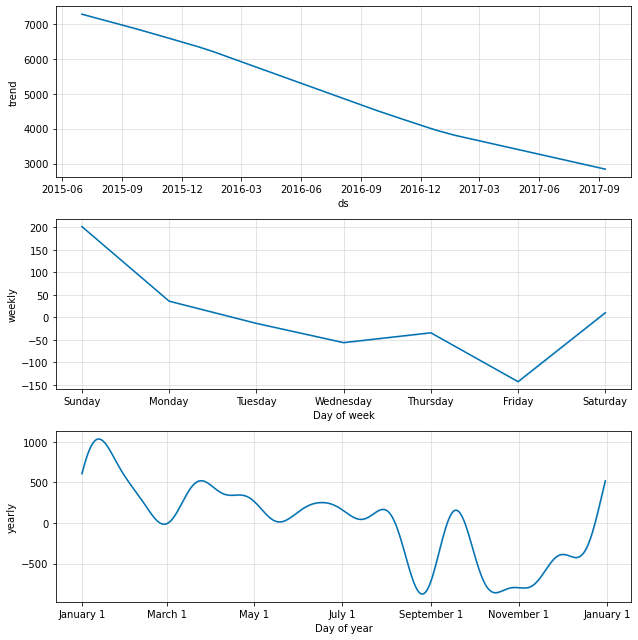

In [ ]:
#page 4
i=3
sample1, page1, a, b = doprophet(i)

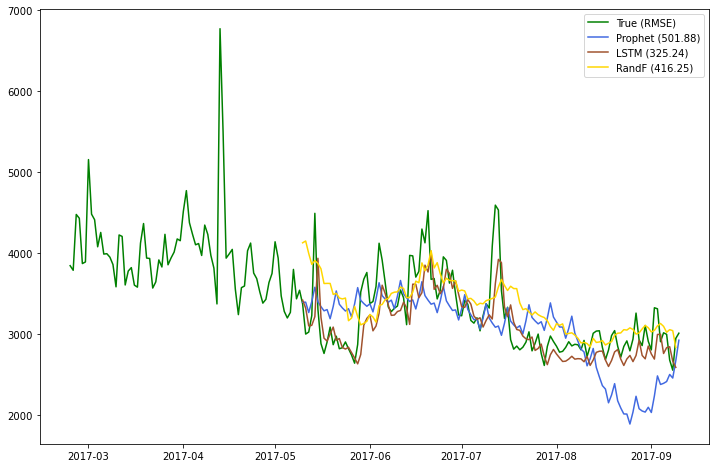

In [ ]:
rmsepro = rmse(np.array(page1.iloc[-124:-1,:]['yhat']), np.array(sample1.iloc[-124:-1,:]['y']))
rmselst = rmse(np.array(lstm.iloc[-124:-1,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))
rmserfr = rmse(np.array(v.iloc[:,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))

drawconclusion(sample1, page1, a, b)

In [ ]:
print(rmsepro)
print(rmselst)
print(rmserfr)

501.8778257835404
325.2421472453285
416.2461920827313


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -14.1839
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75        2007.4   0.000357497       83.4235   6.812e-06       0.001      132  LS failed, Hessian reset 
      99       2007.77    0.00167102       86.8709      0.8709      0.8709      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2007.79   0.000365803       176.309   4.248e-06       0.001      201  LS failed, Hessian reset 
     149       2008.13   0.000168518        84.167   3.703e-06       0.001      295  LS failed, Hessian reset 
     199       2008.37   3.10293e-05       68.7528      0.3547           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2008.46   0.000171537       78.8817           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/jinyingzhe/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

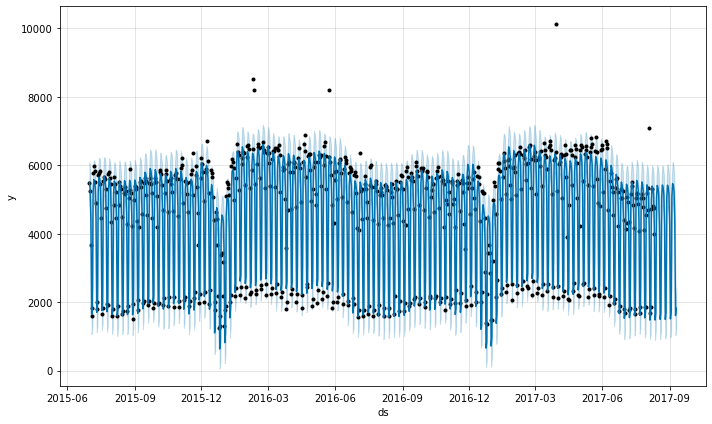

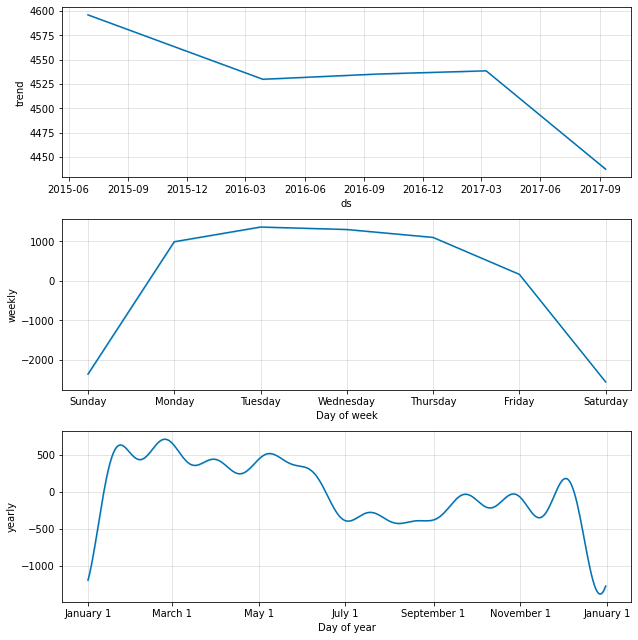

In [ ]:
#page 5
i=4
sample1, page1, a, b = doprophet(i)

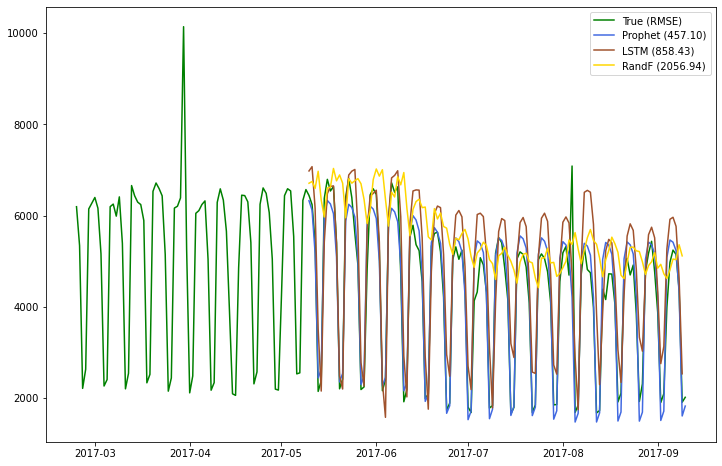

In [ ]:
rmsepro = rmse(np.array(page1.iloc[-124:-1,:]['yhat']), np.array(sample1.iloc[-124:-1,:]['y']))
rmselst = rmse(np.array(lstm.iloc[-124:-1,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))
rmserfr = rmse(np.array(v.iloc[:,:][b]), np.array(sample1.iloc[-124:-1,:]['y']))

drawconclusion(sample1, page1, a, b)

In [ ]:
print(rmsepro)
print(rmselst)
print(rmserfr)

457.0952914020477
858.4346515552857
2056.944650827999
